# Resample Time-Series

In [1]:
import pandas as pd
from glob import glob

def get_shortest_ts():
    files = glob('Z:\Descargas\CSV_DATA\*.csv')
    min_samples = 999999999999
    file_min = None
    for file in files:
        df = pd.read_csv(file)
        row_count = df.shape[0]
        if row_count < min_samples:
            min_samples = row_count
            file_min = file
            print(file, str(row_count))
            #if min_samples == 832:
            #    break
    return min_samples, file_min

get_shortest_ts()

Z:\Descargas\CSV_DATA\0.csv 857
Z:\Descargas\CSV_DATA\1015.csv 832


(832, 'Z:\\Descargas\\CSV_DATA\\1015.csv')

![](img/composite.PNG)

In [5]:
from scipy import signal
from glob import glob
import pandas as pd

def resample_data():
    size = 832
    files = glob('Z:\Descargas\CSV_DATA\*.csv')
    for file in files:
        df = pd.read_csv(file)
        col_names = ('Flow rate', 'Pressure')
        col_names = ('Flow rate', 'Zone9_Pressure', 'Zone16_Pressure', 'Zone17_Pressure', 'Zone24_Pressure')
        cols = [col for col in df if col.endswith(col_names)]    
        resampled_df = pd.DataFrame(signal.resample(df[cols], int(832)))
        resampled_df['TOTAL_QUALITY'] = df['TOTAL_QUALITY']
        resampled_df.to_csv(file.replace('CSV_DATA', 'CSV_DATA_RESAMPLED'))
        
resample_data()

# FROM 3D to 2D

In [6]:
import os
from glob import glob
import pandas as pd
         
def convert_ts_into_2D():
    files = glob('Z:\Descargas\CSV_DATA_RESAMPLED\*.csv')
    for file in files:
        df = pd.read_csv(file)
        df = df.loc[:, ~df.columns.str.contains('^Unnamed')].T
        series = None
        for index, row in df.iterrows():
            if index == 'TOTAL_QUALITY':
                series = pd.concat([series, pd.Series(int(row[0]), dtype=object)])               
            else:
                series = pd.concat([series, row])               
         
        #series = series.reset_index(drop=True)  
        new_df = pd.DataFrame().append(pd.Series(list(series)), ignore_index=True)
        # append series into csv
        output_file = 'Z:\\Descargas\\resampled_2d_data.csv'
        if not os.path.isfile(output_file):
            new_df.to_csv(output_file)
        else:
            new_df.to_csv(output_file, mode='a', header=False)            
        
convert_ts_into_2D()

### Scale the data

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('Z:\\Descargas\\resampled_2d_data.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

df = None
#dfs = np.split(X, 29, axis=1) # 29 sensors, each sensor 832 columns
dfs = np.split(X, 5, axis=1)

In [9]:
# http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.862.1452&rep=rep1&type=pdf
import math
    
def group_scalling(df):    
    Uj = np.mean(df.values)    
    Qj2 = np.mean(((df - Uj)**2).values)    
    new_df = df.copy() 
    for col in df:
        new_df[col] = (new_df[col] - np.mean(new_df[col])) / math.sqrt(Qj2)      
    return new_df 

scalled_dfs = []
for df in dfs: 
    scalled_df = group_scalling(df)   
    scalled_dfs.append(scalled_df)
dfs = None
    
len(scalled_dfs)

5

In [10]:
scalled_df = pd.concat(scalled_dfs, axis=1)
scalled_df['target'] = y
scalled_df

,0,1,2,3,4,5,6,7,8,9,...,4151,4152,4153,4154,4155,4156,4157,4158,4159,target
0,-0.026300,0.012386,-0.008092,0.005742,-0.005080,0.003726,-0.003559,0.002265,-0.002652,0.001683,...,-1.799171,-1.777926,-1.808668,-1.776635,-1.798714,-1.724143,-1.729821,-1.593342,-1.872527,1.0
1,-0.026291,0.012375,-0.008077,0.005730,-0.005055,0.003726,-0.003555,0.002278,-0.002637,0.001679,...,-1.745006,-1.711579,-1.741869,-1.704129,-1.695839,-1.628818,-1.632704,-1.498414,-1.776719,0.0
2,-0.026287,0.012373,-0.008197,0.005746,-0.004566,0.003258,-0.003556,0.002317,-0.002931,0.001599,...,-1.690877,-1.720176,-1.775703,-1.725429,-1.737408,-1.720821,-1.771621,-1.733746,-1.967240,1.0
3,-0.026338,0.012398,-0.008062,0.005738,-0.004903,0.003814,-0.003600,0.002545,-0.002659,0.001805,...,-1.500119,-1.466589,-1.475559,-1.429498,-1.410127,-1.338661,-1.268137,-1.184127,-1.439020,0.0
4,-0.026354,0.012393,-0.008022,0.005709,-0.004736,0.003864,-0.002941,0.002987,-0.002444,0.002208,...,-1.142481,-1.164907,-1.177940,-1.201010,-1.217921,-1.235709,-1.277332,-1.275266,-1.554896,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10009,-0.026215,0.012354,-0.007746,0.007024,-0.003921,0.004430,-0.002762,0.002972,-0.001778,0.003094,...,-0.105710,-0.116192,-0.140454,-0.151895,-0.177162,-0.187374,-0.232111,-0.243973,-0.502269,1.0
10010,-0.026361,0.012392,-0.007986,0.005731,-0.004498,0.003870,-0.002851,0.002938,-0.002329,0.001862,...,1.404091,1.386155,1.387888,1.362908,1.366994,1.336298,1.329804,1.282070,1.127070,1.0
10011,-0.026332,0.012375,-0.007990,0.005694,-0.004622,0.003822,-0.002967,0.002907,-0.002355,0.001878,...,-0.530891,-0.524270,-0.536774,-0.531969,-0.546175,-0.524012,-0.547707,-0.508145,-0.707498,1.0
10012,-0.026326,0.012366,-0.007977,0.005688,-0.004589,0.003818,-0.002935,0.002900,-0.002335,0.001857,...,-0.531561,-0.524025,-0.534427,-0.530749,-0.544126,-0.523017,-0.545251,-0.507784,-0.703672,1.0


In [11]:
scalled_df.to_csv('Z:\\Descargas\\resampled_ts_group_scalled.csv')

# DETECT ANOMALIES

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('Z:\\Descargas\\resampled_ts_group_scalled.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
df = pd.DataFrame(X)
df['target'] = y

# Divide dataframe depending on target
df_correct = df.loc[df['target'] == 1]
df_incorrect = df.loc[df['target'] == 0]

# Print each target shape
print('Target 1 shape: ' + str(df_correct.shape))
print('Target 0 shape: ' + str(df_incorrect.shape))

Target 1 shape: (5055, 4161)
Target 0 shape: (4959, 4161)


In [2]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

df_train, df_test_correct = train_test_split(df_correct, test_size=0.2, random_state=0)
df_test_incorrect = df_incorrect

X_train = df_train.iloc[:,:-1]
X_test_correct = df_test_correct.iloc[:,:-1]
X_test_incorrect = df_test_incorrect.iloc[:,:-1]

### PCA

In [3]:
import numpy as np
from sklearn.decomposition import PCA
from models.model import ReconstructionErrorModel

# Fit reconstruction error model with correct data
model = ReconstructionErrorModel(X_train, model=PCA(n_components=0.9))

# Calculate anomaly threshold with correct data
train_errors = model.predict(X_train)
threshold = np.mean(train_errors) + (np.std(train_errors) * 3)

# Print principal components
print(threshold)
print('%i Principal Components' % len(model.get_model().explained_variance_))

0.29364827120675585
2 Principal Components


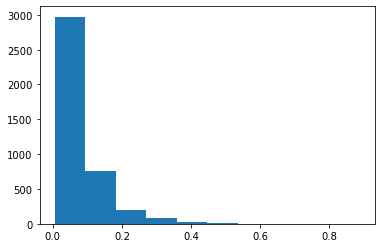

In [9]:
import matplotlib.pyplot as plt

plt.hist(model.predict(X_train))
plt.show()

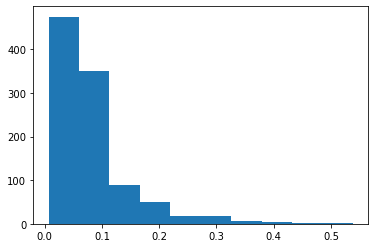

In [10]:
import matplotlib.pyplot as plt

plt.hist(model.predict(X_test_correct))
plt.show()

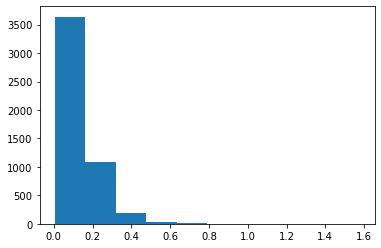

In [12]:
import matplotlib.pyplot as plt

plt.hist(model.predict(X_test_incorrect))
plt.show()

In [25]:
threshold = 0.08

In [26]:
# Calculate how many train instances are detected as anomalies
errors = model.predict(X_train)
anomalies = np.where(errors > threshold)[0]
print('Anomalies with train data %s' % str(len(anomalies)))

# Calculate how many test correct instances are detected as anomalies
errors = model.predict(X_test_correct)
anomalies = np.where(errors > threshold)[0]
print('Anomalies with test correct data %s' % str(len(anomalies)))

# Calculate how many test incorrect instances are detected as anomalies
errors = model.predict(X_test_incorrect)
anomalies = np.where(errors > threshold)[0]
print('Anomalies with test incorrect data %s' % str(len(anomalies)))

Anomalies with train data 1414
Anomalies with test correct data 357
Anomalies with test incorrect data 3057
